In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
news_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /home/ssac19/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
news_data.sample(10)
#test가 본문, headline이 요약본

,headlines,text
12090,24-yr-old 1st female Indian wrestler in 6 yrs ...,India's 24-year-old Pooja Dhanda became the fi...
70807,Those who litter shouldn't chant Vande Mataram...,"Addressing a students' convention in Delhi, PM..."
26857,24-year-old actress rescued as cops bust prost...,Police have rescued a 24-year-old budding film...
40556,Congress MP slams website calculating dowry ba...,Congress MP Jyotiraditya Scindia has slammed a...
95569,UP govt to roll back ration cards with Akhiles...,The Yogi Adityanath government in Uttar Prades...
79358,Game of Thrones season 7 premiere pirated 9 cr...,"As per piracy monitor Muso, the premiere episo..."
77961,Stokes 1st Englishman to hit 3 6s in a row in ...,England's Ben Stokes hit three consecutive six...
45781,Minor girls booked for inserting wood in 7-yr-...,Three minor girls have been booked for alleged...
50618,TPG Global led consortium bids $1 bn for Tata ...,Investment firm TPG Global led consortium has ...
66837,Taj Mahal gives jobs to many people: Akhilesh ...,Days after BJP-led Uttar Pradesh government wa...


### - 데이터 전처리하기(추상적 요약)

In [3]:
#데이터 속의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', news_data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', news_data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [4]:
#text가 다르지만, summary는 같을 수도 있기에 text의 중복은 제거해야 한다.
news_data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(news_data)))

전체 샘플수 : 98360


In [5]:
print(news_data.isnull().sum())

headlines    0
text         0
dtype: int64


In [6]:
# it will은 it'll은 똑같은 의미이기에 하나로 통일하여 연산량을 줄일 수 있다.
# 이런 것이 텍스트 정규화
# 아래의 딕셔너리는 같은 의미를 가진 것들을 key와 밸류로 묶어놓았다.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [7]:
# 텍스트에는 자주 나오지만, 자연어 처리시에 도움이 되지 않는 단어들을 불용어(stopwords라고 하는데
# 제거해서 연산량을 줄이면 성능이 좋아진다.
# 우리는 NLTK에서 주어진 불용어 리스트 사용
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 데이터 전처리 함수
# text에 있는 불용어는 제거하고, summary의 불용어는 제거하지 않는다.
# summary의 불용어를 제거하면 나오는 문장이 어색할 수 있기 때문에.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)(기본값이 True이기에 아무것도 안넣으면 실행)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary) (함수를 불러올 떄 false값을 넣어줘야 실행)
    else: 
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
clean_news = []#전처리된 텍스트 리스트.

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in news_data['text']:
    clean_news.append(preprocess_sentence(s))#전처리하고 리스트에 넣기

# 전처리 후 출력
clean_news[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [10]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in news_data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))#전처리하고 리스트에 넣기

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [11]:
#전처리한 값들을 다시 데이터프레임에 넣는다.
news_data['text'] = clean_news
news_data['headlines'] = clean_headlines

# 정제한 후에 값이 비게 될 수 있으므로 
# 빈 값을 Null 값으로 변환
news_data.replace('', np.nan, inplace=True)

In [12]:
#전처리 후에 summary에 0개의 빈값이 생겼다.
news_data.isnull().sum()

headlines    0
text         0
dtype: int64

In [13]:
#빈 샘플들은 제거
news_data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(news_data)))#데이터 전처리 함수

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


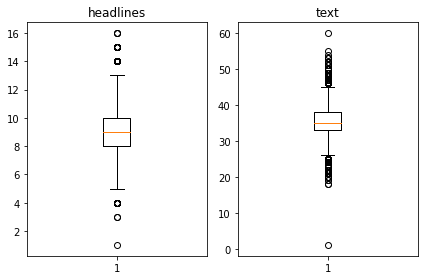

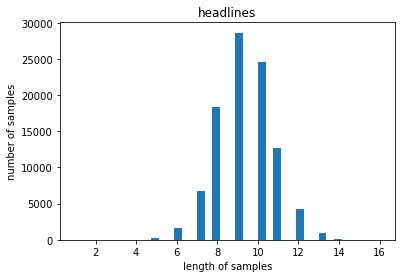

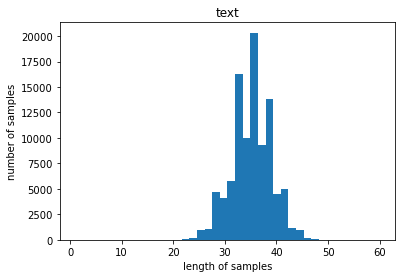

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in news_data['text']]
headlines_len = [len(s.split()) for s in news_data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
#그래프를 보면 text는 대체로 35내외의 길이를 가지고, summary는 9이내의 길이.
#각각의 최댓값을 임시로 정해보자
text_max_len = 40
headlines_max_len = 10

In [16]:
# 훈련데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당되는지 확인하는 함수 
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
#텍스트최대길이를 40으로 잡으면 8%가 날라감.
below_threshold_len(text_max_len, news_data['text'])
below_threshold_len(headlines_max_len,  news_data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [18]:
#이번 프로젝트에서는 최대길이보다 큰 샘플들을 최대길이로 자르는 것이 아니라 최대길이보다 작은 것들만 남긴다
news_data = news_data[news_data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
news_data = news_data[news_data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(news_data)))

전체 샘플수 : 74102


In [19]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
news_data['decoder_input'] = news_data['headlines'].apply(lambda x : 'sostoken '+ x)
news_data['decoder_target'] = news_data['headlines'].apply(lambda x : x + ' eostoken')
news_data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [20]:
# 각각 numpy array로 저장
encoder_news_input = np.array(news_data['text']) # 인코더의 입력
decoder_news_input = np.array(news_data['decoder_input']) # 디코더의 입력
decoder_news_target = np.array(news_data['decoder_target']) # 디코더의 레이블

In [21]:
#훈련 데이터와 테스트 데이터 분리
#순서를 섞은 정수 시퀀스 생성.
indices = np.arange(encoder_news_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 7718 66438 24964 ...   413 69787 26840]


In [22]:
encoder_news_input = encoder_news_input[indices]
decoder_news_input = decoder_news_input[indices]
decoder_news_target = decoder_news_target[indices]

In [23]:
#8:2로 훈련, 테스트 데이터 분리. 
n_of_val = int(len(encoder_news_input)*0.2)#테스트 데이터 갯수
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 14820


In [24]:
#:-n_of_val = :n_of_val+1
encoder_input_train = encoder_news_input[:-n_of_val]
decoder_input_train = decoder_news_input[:-n_of_val]
decoder_target_train = decoder_news_target[:-n_of_val]

encoder_input_test = encoder_news_input[-n_of_val:]
decoder_input_test = decoder_news_input[-n_of_val:]
decoder_target_test = decoder_news_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


In [25]:
#이렇게 해서 만들어진 단어집합은 src_tokenizer.word_index에 저장.
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
#단어집합에 저장된 모든 단어를 사용하는게 아니라 빈도수가 적은 것을 빼고 돌려야 학습에 큰 문제가 없으면서 비용절감이 가능.
#빈도 수가 7보다 작은 것들에 대한 통계정보
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61493
등장 빈도가 9번 이하인 희귀 단어의 수: 45569
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15924
단어 집합에서 희귀 단어의 비율: 74.10436960304425
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.481076324871868


In [27]:
#10번보다 작게 등장하는 단어집합의 크기가 15886로 15000으로 어림잡아 단어집합 재생성
src_vocab = 15000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#단어집합의 크기를 15000으로 정해놨기에 이제 정수 인코딩후에 15000이 넘는 숫자가 있을 수가 없다.
#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[831, 2857, 6063, 5810, 48, 2024, 804, 2025, 3204, 1365, 13637, 228, 3713, 327, 869, 279, 6063, 1, 7513, 9475, 2319, 4760, 8275, 62, 13637, 1502, 12619, 560, 700, 599, 805, 1202], [2, 15, 64, 47, 2943, 2105, 1125, 30, 206, 1715, 168, 1073, 5676, 494, 80, 221, 2650, 559, 409, 813, 4305, 30, 206, 704, 429, 5452, 1125, 168, 1316, 10631, 494, 1], [22, 1536, 294, 460, 136, 3051, 2637, 79, 11, 23, 202, 1046, 7939, 37, 465, 6064, 915, 22, 101, 1536, 294, 467, 2259, 79, 87, 23, 2858, 1046, 1203, 1544, 7939, 3938, 3092, 381, 1046, 437, 23, 381, 7939]]


In [29]:
#summary 데이터도 동일하게 단어사전생성
#단어에 부여된 고유한 정수는 tar_tokenizer.word_index에 저장
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
#tar_tokenizer.word_counts.items()에 단어와각 단어의 등장 빈도수 저장되어 있다.
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27263
등장 빈도가 7번 이하인 희귀 단어의 수: 19717
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7546
단어 집합에서 희귀 단어의 비율: 72.32146132120457
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.628386866474914


In [31]:
#이번에도 단어집합을 어림잡아 2000으로 잡고 단어사전 재생성
tar_vocab = 7500
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3325, 1653, 49, 468, 13, 550, 182, 2133], [1, 35, 2052, 711, 4, 129, 5418, 7, 472, 4, 473], [1, 233, 743, 18, 1008, 1009, 3, 1195, 541, 11, 4664], [1, 58, 48, 2001, 919, 146, 4, 6102, 379], [1, 223, 137, 85, 179, 687, 11, 3557]]
target
decoder  [[3325, 1653, 49, 468, 13, 550, 182, 2133, 2], [35, 2052, 711, 4, 129, 5418, 7, 472, 4, 473, 2], [233, 743, 18, 1008, 1009, 3, 1195, 541, 11, 4664, 2], [58, 48, 2001, 919, 146, 4, 6102, 379, 2], [223, 137, 85, 179, 687, 11, 3557, 2]]


In [32]:
#빈도수가 낮은 단어를 제거하면서 길이가 0인 샘플이 생길 수도 있다.
#decoder_input에는 sostoken decoder_target에는 eostoken이 붙어 있길래 실제 길이가 0인 샘플은 1로 나온다.
#길이가 1인 샘플의 인덱스들을 각각 drop_train, drop_test에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
#텍스트 시퀀스를 정수 시퀀스로 바꾸었다면 샘플들의 길이를 맞추기 위해서 패딩함. 최대길이로 패딩하며 길이가 짧은 샘플뒤에 0을 넣어줄 것임.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

In [34]:
#함수형 api활용하여 인코더 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 #임베딩 벡터 차원
hidden_size = 256 #LSTM에서 얼만큼의 수용력을 가질지 결정.(LSTM의 용량 크기 혹은 뉴론 갯수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1 3층이어서 모델의 용량을 늘림
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)#LSTM 입력정의시, 인코더의 hidden state, cell state 넣어줘야 한다.
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
#summary의 단어장중에서 하나의 단어를 선택하는 다중 분류 문제이므로 softmax사용.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 512), (N 1312768     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### - 어텐션 메커니즘 사용하기(추상적 요약)

In [37]:
#어텐션 매커니즘 설계는 새로운 신경망 설계. 우리는 일단 만들어진 것을 불러와서 사용
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [38]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 512), (N 1312768     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, callbacks=[es], epochs = 50)
#earlystop은 조건이 충족되면 모델 훈련 중단.
#여기서는 val_loss를 모니터링하며 증가하는 증상이 2번 보이면 조기종료
# batch_size = 256 hidden_size = 256, epoch: 27 loss: 2.8436 - val_loss: 3.9859

Epoch 1/50
464/464 [==============================] - 173s 373ms/step - loss: 5.9446 - val_loss: 5.5430
Epoch 2/50
464/464 [==============================] - 171s 369ms/step - loss: 5.3333 - val_loss: 5.1876
Epoch 3/50
464/464 [==============================] - 173s 374ms/step - loss: 4.9591 - val_loss: 4.8564
Epoch 4/50
464/464 [==============================] - 169s 365ms/step - loss: 4.6570 - val_loss: 4.6359
Epoch 5/50
464/464 [==============================] - 168s 363ms/step - loss: 4.3939 - val_loss: 4.4779
Epoch 6/50
464/464 [==============================] - 169s 364ms/step - loss: 4.1791 - val_loss: 4.3572
Epoch 7/50
464/464 [==============================] - 169s 364ms/step - loss: 3.9933 - val_loss: 4.2846
Epoch 8/50
464/464 [==============================] - 169s 364ms/step - loss: 3.8391 - val_loss: 4.2121
Epoch 9/50
464/464 [==============================] - 168s 362ms/step - loss: 3.6947 - val_loss: 4.1701
Epoch 10/50
464/464 [==============================] - 168s 363m

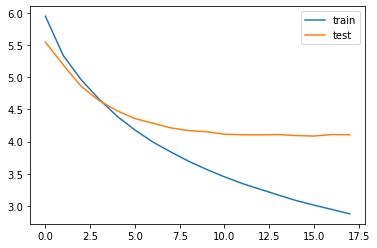

In [40]:
#훈련, 검증 데이터 손실을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
#훈련시에는 정답문장(summary)를 넣고 디코더의 출력과 비교가 가능해서 인코더와 디코더를 엮은 모델하나만 준비
#하지만 정답문장이 없는 실제 상황에서는 만들어야 할 문장길이만큼 디코더가 반복적으로 동작해야 하므로 별도 모델 설계 필요. 이때 인코더, 디코더 모델 분리설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### - 실제 결과와 요약문 비교하기(추상적 요약)

In [48]:
#테스트 결과를 보기 위해서는 정수 시퀀스-> 텍스트 시퀀스
#패딩을 위한 0, 시작토큰, 종료토큰의 인덱스는 제외하고 변환
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
#실제 요약과 예측된 요약비교
#나름대로 비슷한 요약도 있다. 여러 개선방안이 존재(트랜스포머, 빔서치, 사전 훈련된 워드 임베딩)
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : central bureau investigation told parliamentary panel today may bofors case crore scandal rajiv gandhi government swedish radio april claimed swedish arms manufacturer bofors ab paid bribes top indian politicians defence personnel crore deal 
실제 요약 : case may be cbi tells parliamentary panel 
예측 요약 :  cbi seeks cr scam from india


원문 : court documents revealed blood testing startup valued billion ran fake demonstration tests prospective investors complaint based testimony former employees directors claims used commercial devices instead one drop blood testing technology cheat investors business partners 
실제 요약 : blood testing startup tests to investors lawsuit 
예측 요약 :  startup develops cr for startup for billion


원문 : reacting anti romeo squads formed uttar pradesh senior congress leader digvijaya singh saturday asked online troll abuse opposing task force tweeted notably cm yogi adityanath directed officials lay clear guidelines anti romeo squads 
실제 요약 : what about online who

예측 요약 :  delhi approves its airport spinner to


원문 : delhi university tuesday released fifth final cut list per schedule admissions list conclude july courses closed general category students several colleges highest cut fifth list college percent ba psychology 
실제 요약 : delhi university releases final cut off list 
예측 요약 :  delhi university tops list of most advanced


원문 : bishop international airport us state michigan evacuated police officer stabbed neck man according reports suspect along knife reportedly detained police injured officer critical condition reports added airport closed notice 
실제 요약 : airport in us evacuated after cop stabbed in neck 
예측 요약 :  tourist detained in uk parliament officer case


원문 : uae man fined lakh sent jail days fianc took serious offence jokingly called messaging app whatsapp following message fianc filed court case per law sending anything offensive nature social media considered 
실제 요약 : uae man calls fianc idiot on whatsapp fined lakh 
예측 요약 : 

예측 요약 :  rajasthan cm announces lakh for railway ministers




### - Summa를 이용해서 추출적 요약해보기

In [53]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
news_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /home/ssac19/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
origin_text = news_data
fixed_index_data = origin_text.reset_index()
#print(fixed_index_data)
print(fixed_index_data)
txt = fixed_index_data['text']
heads = fixed_index_data['headlines']
print(txt)
print(type(txt))

       index                                          headlines  \
0          0  upGrad learner switches to career in ML & Al w...   
1          1  Delhi techie wins free food from Swiggy for on...   
2          2  New Zealand end Rohit Sharma-led India's 12-ma...   
3          3  Aegon life iTerm insurance plan helps customer...   
4          4  Have known Hirani for yrs, what if MeToo claim...   
...      ...                                                ...   
98396  98396  CRPF jawan axed to death by Maoists in Chhatti...   
98397  98397  First song from Sonakshi Sinha's 'Noor' titled...   
98398  98398         'The Matrix' film to get a reboot: Reports   
98399  98399  Snoop Dogg aims gun at clown dressed as Trump ...   
98400  98400  Madhesi Morcha withdraws support to Nepalese g...   

                                                    text  
0      Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1      Kunal Shah's credit card bill payment platform...  
2      New Zealand

In [66]:
import requests
from summa.summarizer import summarize
for i in range(50, 100):
    print('original text:')
    print(txt[i])
    print('original headline:')
    print(heads[i])
    print('predicted summary:')
    print(summarize(txt[i], ratio=0.5))
    print('-----------------------------')
  

original text:
Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
original headline:
Yashwant Sinha demands probe into alleged fund diversion by DHFL
predicted summary:
Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
-----------------------------
original text:
US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained i

추출적 요약은 핵심단어가 들어가있지만, 반복되어 있거나, 문법적인 오류가 있으며
추상적 요약은 ratio에 따라 아예 생성되지 않는 경우도 존재하며, 문법적인 오류가 여전히 있다. ratio에 따라 원문에서 발췌되는 정도가 결정되기 때문에 핵심단어의 여부도 ratio에 따라 달라진다.